<div align="center"><h3>HW3, Question 6</h3></div>
<div align="center"><h5>Mohammadreza Ghofrani, 400131076</h5></div>

In [1]:
import glob
from collections import Counter
import cv2
import sklearn
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt

# Constants

In [2]:
N = 821
M = 73
C = 40
IMAGE_WIDTH = 60
IMAGE_HEIGHT = 80
IMAGE_FLATTEN_LENGTH = IMAGE_WIDTH * IMAGE_HEIGHT

# Initializing

In [3]:
trainset = np.zeros((IMAGE_FLATTEN_LENGTH, N))
trainlabels = list()
for i, image_path in enumerate(glob.glob('data/P6/LFW/train/**')):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    trainset[:, i] = img.flatten()
    trainlabels.append(image_path.split('/')[-1].split('\\')[-1].split('.')[0][:-3])

In [4]:
testset = np.zeros((IMAGE_FLATTEN_LENGTH, M))
testlabels = list()
for i, image_path in enumerate(glob.glob('data/P6/LFW/test/**')):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    testset[:, i] = img.flatten()
    testlabels.append(image_path.split('/')[-1].split('\\')[-1].split('.')[0])

# Part A

In [5]:
def eigenfaces_train(trainset, v):
    mu = np.mean(trainset, axis=1)[np.newaxis]
    zero_mean_trainset = trainset - mu.T

    scatter = (N - 1) * np.cov(zero_mean_trainset)
    eigenvalues, eigenvectors = np.linalg.eig(scatter)

    sorted_eigenvalues_index = np.argsort((-1) * eigenvalues)[:v]
    return eigenvectors[:, sorted_eigenvalues_index], mu

In [6]:
W, mu = eigenfaces_train(trainset, 50)

# Part B

C:\Users\engmrgh\AppData\Local\Temp\ipykernel_20188\1141614550.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


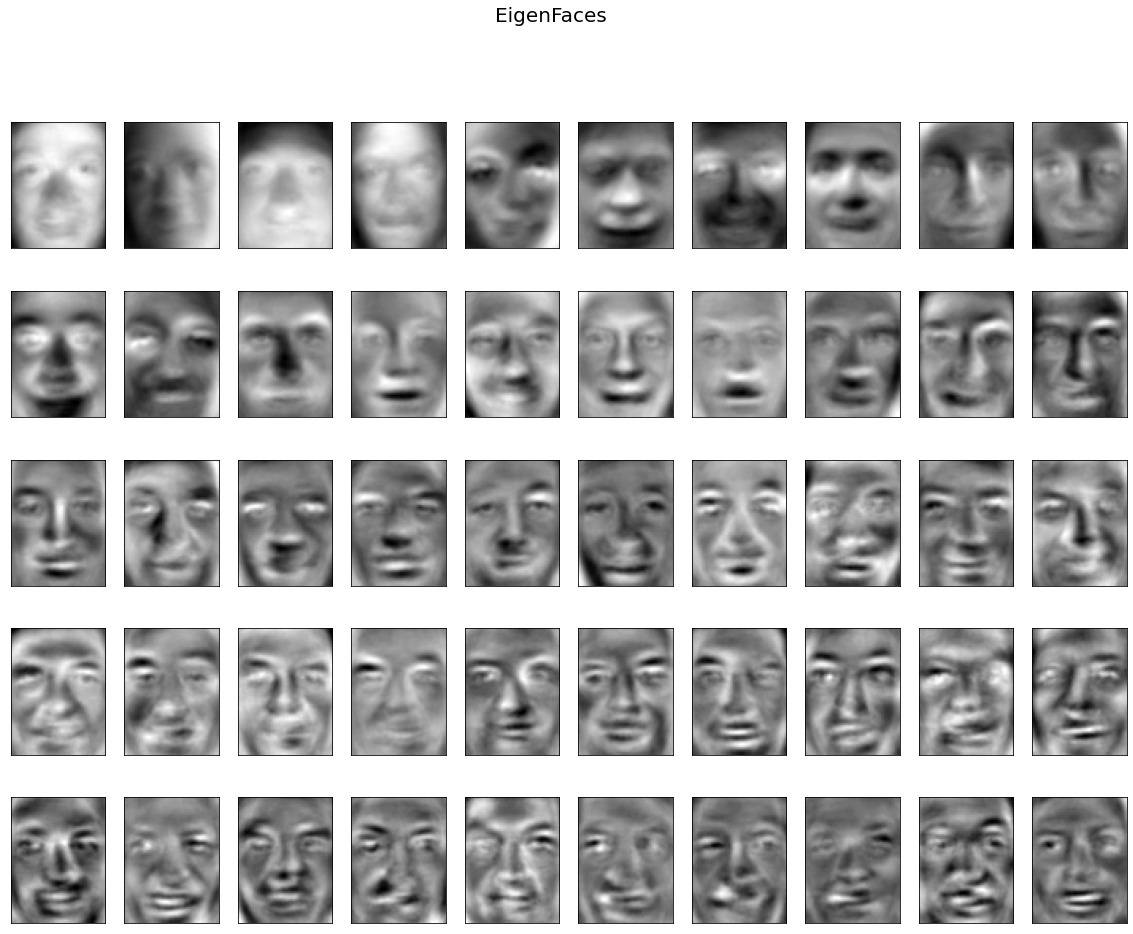

In [7]:
fig, ax = plt.subplots(5, 10, subplot_kw=dict(xticks=[], yticks=[]))
for i, eigenface in enumerate(W.T):
    im = ax[i//10, i%10].imshow(np.real(eigenface.reshape(IMAGE_HEIGHT,IMAGE_WIDTH)), cmap='gray')
fig.suptitle('EigenFaces', fontsize=20)
fig.set_size_inches(20,15)
fig.show()

# Part C

C:\Users\engmrgh\AppData\Local\Temp\ipykernel_20188\299571014.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


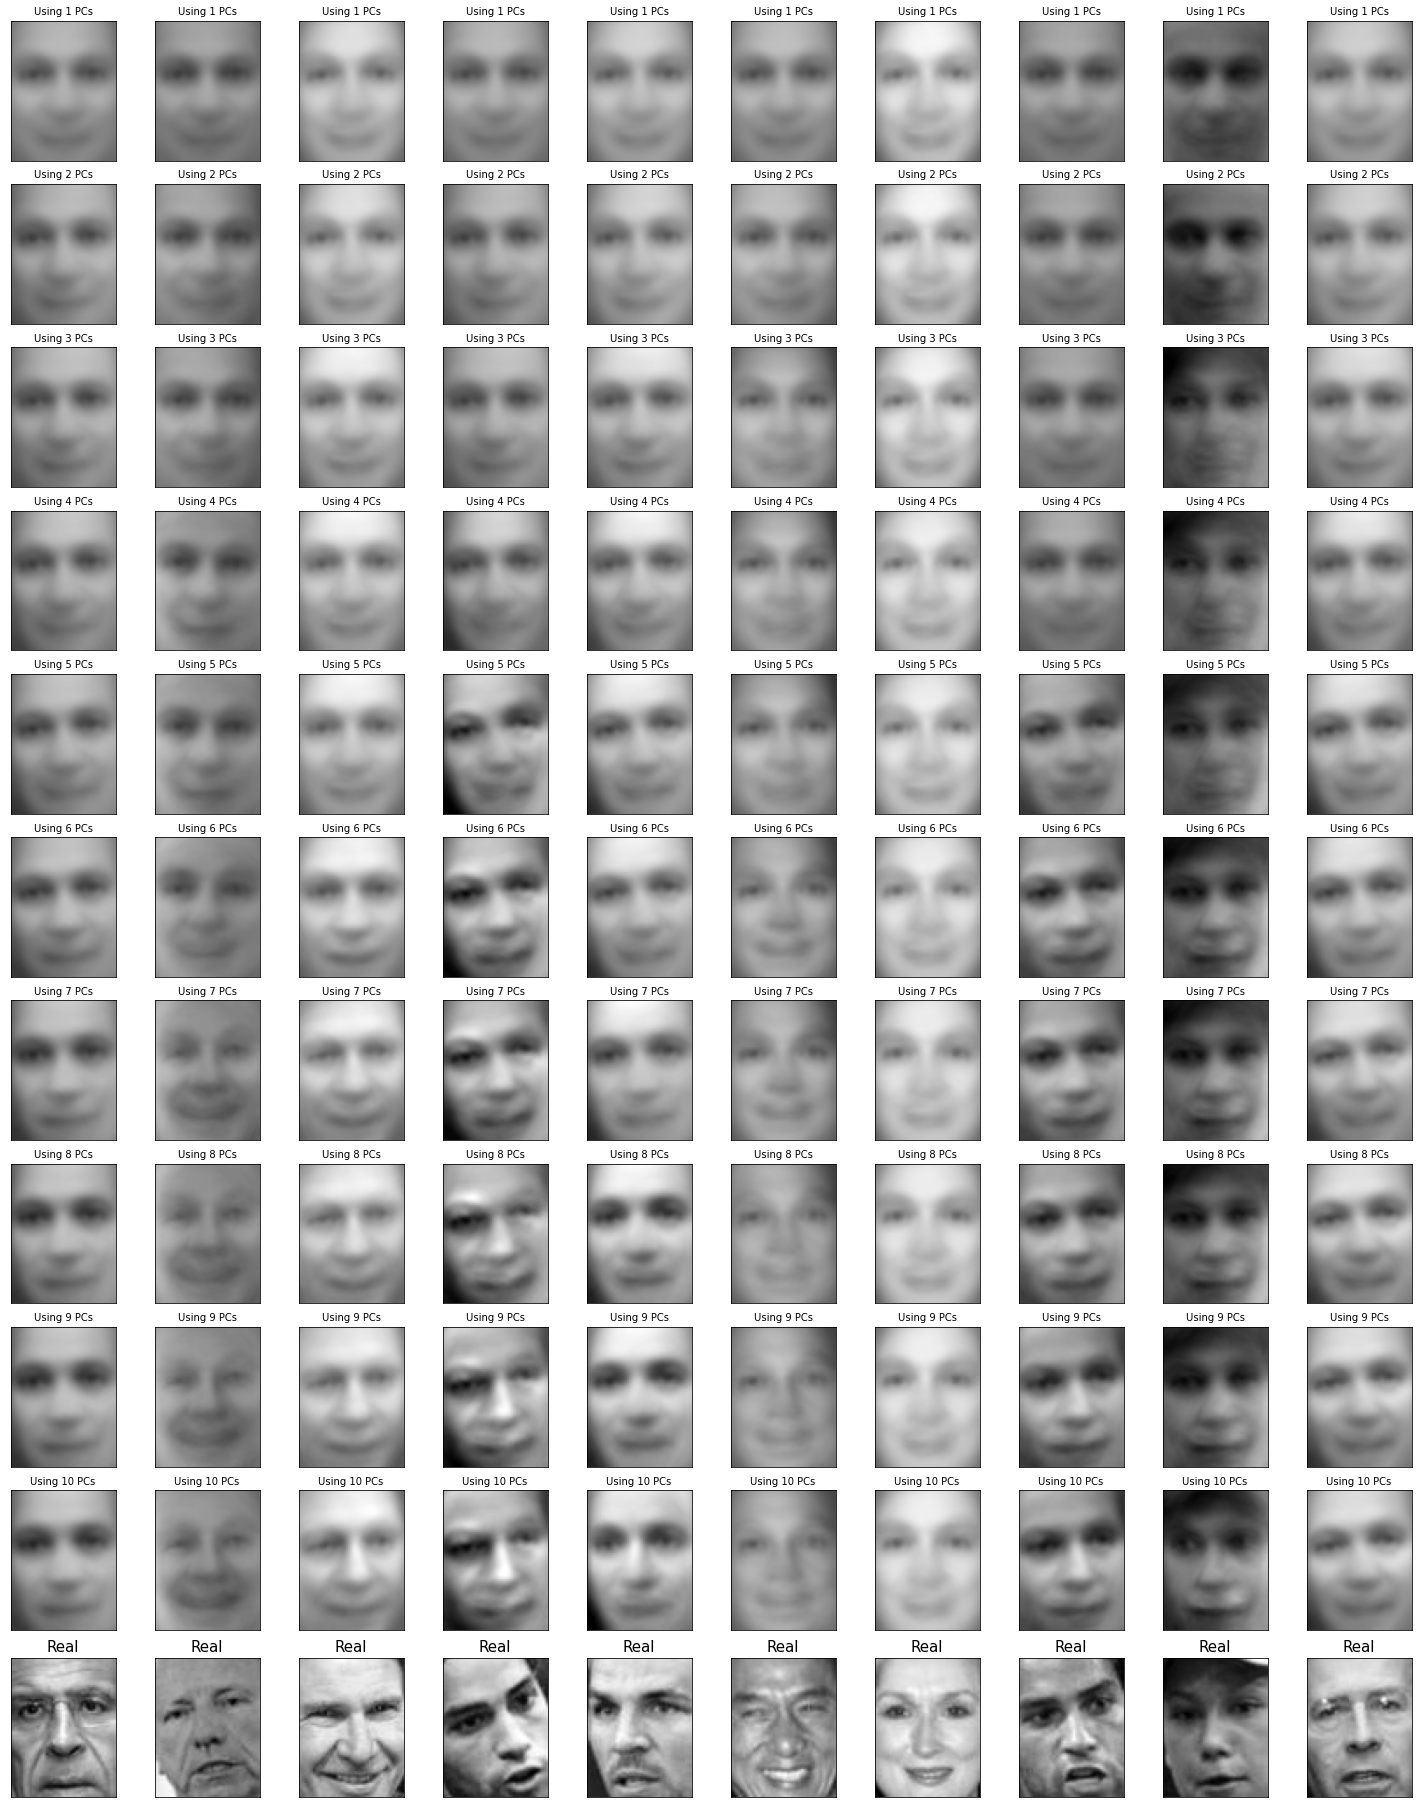

In [8]:
random_sample_indices = np.random.randint(low=0, high=N, size=10)
random_samples = trainset[:, random_sample_indices]

fig, ax = plt.subplots(11, 10, subplot_kw=dict(xticks=[], yticks=[]), constrained_layout=True)
for v in range(1, 10+1):
    w = W[:,:v]
    random_samples_projected = w.T @ (random_samples - mu.T)
    random_samples_reconstructed = w @ random_samples_projected + mu.T

    for i, sample in enumerate(random_samples_reconstructed.T):
        ax[v-1, i].set_title(f'Using {v} PCs', fontsize=10)
        ax[v-1, i].imshow(sample.reshape(IMAGE_HEIGHT,IMAGE_WIDTH).real, cmap='gray', vmin=0, vmax=255)
for i, sample in enumerate(random_samples.T):
    ax[10, i].set_title(f'Real', fontsize=15)
    ax[10, i].imshow(np.real(sample.reshape(IMAGE_HEIGHT,IMAGE_WIDTH)), cmap='gray', vmin=0, vmax=255)
fig.set_size_inches(20,25)
fig.show()

# Part D

In [9]:
def eigenfaces_test(trainset, trainlabels, testset, W, mu, v):
    testlabels = list()
    w = W[:,:v]
    zero_mean_trainset = trainset - mu.T
    zero_mean_testset = testset - mu.T

    projected_trainset = w.T @ zero_mean_trainset
    projected_testtest = w.T @ zero_mean_testset

    for vtest in projected_testtest.T:
        min_distance = float("inf")
        knn_predicted_label = None
        for i, vtrain in enumerate(projected_trainset.T):
            distance = np.linalg.norm(vtest - vtrain)
            if distance < min_distance:
                min_distance = distance
                knn_predicted_label = i
        testlabels.append(trainlabels[knn_predicted_label])
    return testlabels

In [10]:
error_rate = list()
vrange= list(range(1,50+1))
for v in vrange:
    predictedlabels = eigenfaces_test(trainset, trainlabels, testset, W, mu, v)
    error_rate.append(1-sklearn.metrics.accuracy_score(testlabels, predictedlabels))

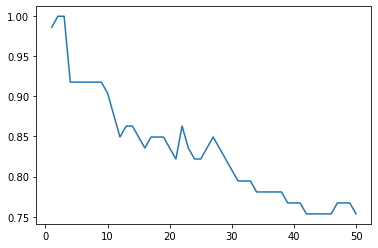

In [11]:
plt.plot(vrange, error_rate)
plt.show()

# Part E

In [12]:
error_rate = list()
vrange= list(range(1,50+1))
for v in vrange:
    predictedlabels = eigenfaces_test(trainset, trainlabels, testset, W[:,5:], mu, v)
    error_rate.append(1-sklearn.metrics.accuracy_score(testlabels, predictedlabels))

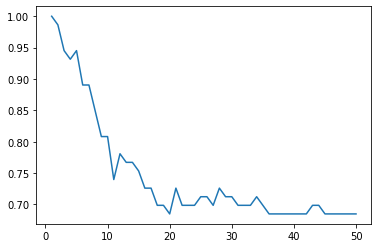

In [13]:
plt.plot(vrange, error_rate)
plt.show()

# Part F

In [14]:
def fisherfaces_train(trainset, trainlabels, c):
    mu = np.mean(trainset, axis=1)[np.newaxis]
    zero_mean_trainset = trainset - mu.T

    scatter = (N - 1) * np.cov(zero_mean_trainset)
    eigenvalues, eigenvectors = np.linalg.eig(scatter)

    sorted_eigenvalues_index = np.argsort((-1) * eigenvalues)[:N-c]
    wpca = eigenvectors[:, sorted_eigenvalues_index].real
    transformed_trainset = wpca.T @ zero_mean_trainset
    transformed_mu = np.mean(transformed_trainset, axis=1)[np.newaxis]

    # calculating Sb
    sb = np.zeros((N-c, N-c))
    s = dict()
    m = dict()
    count = Counter(trainlabels)
    for i, l in enumerate(trainlabels):
        if l in m:
            m[l] += ((1/count[l]) * transformed_trainset[:, i])
        else:
            m[l] = ((1/count[l]) * transformed_trainset[:, i])
    for l, ml in m.items():
        sb += count[l] * (ml-transformed_mu).T @ (ml-transformed_mu)

    # calculating Sw
    sw = np.zeros((N-c, N-c))
    for i, l in enumerate(trainlabels):
        if l in s:
            s[l] += ((transformed_trainset[:, i] - m[l])[np.newaxis].T @ (transformed_trainset[:, i] - m[l])[np.newaxis])
        else:
            s[l] = (transformed_trainset[:, i] - m[l])[np.newaxis].T @ (transformed_trainset[:, i] - m[l])[np.newaxis]
    for sl in s.values():
        sw += sl

    generalized_eigenvalues, generalized_eigenvectors = np.linalg.eig(np.linalg.inv(sw).dot(sb))
    sorted_eigenvalues_index = np.argsort((-1) * generalized_eigenvalues)[:c-1]
    wfld = generalized_eigenvectors[:, sorted_eigenvalues_index].real
    # Note that my vectors are column base. because of this wfld @ wpca has been written as wpca @ wfld
    w = wpca @ wfld
    return w, mu

In [15]:
W, mu = fisherfaces_train(trainset, trainlabels, C)

# Part G

C:\Users\engmrgh\AppData\Local\Temp\ipykernel_20188\2089266065.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


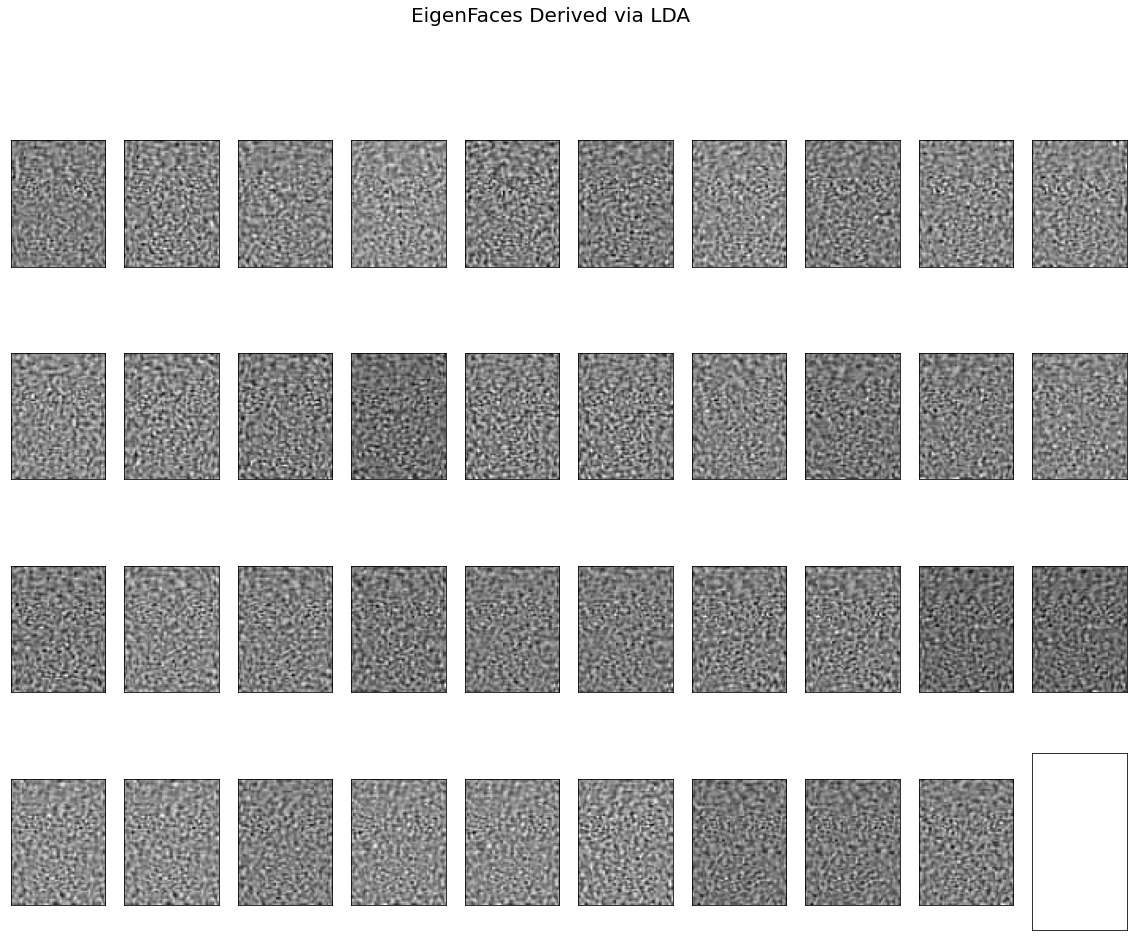

In [16]:
fig, ax = plt.subplots(4, 10, subplot_kw=dict(xticks=[], yticks=[]))
for i, eigenface in enumerate(W.T):
    im = ax[i//10, i%10].imshow(eigenface.reshape(IMAGE_HEIGHT,IMAGE_WIDTH), cmap='gray')
fig.suptitle('EigenFaces Derived via LDA', fontsize=20)
fig.set_size_inches(20,15)
fig.show()

# Part H

In [17]:
error_rate = list()
vrange= list(range(1,39+1))
for v in vrange:
    predictedlabels = eigenfaces_test(trainset, trainlabels, testset, W, mu, v)
    error_rate.append(1-sklearn.metrics.accuracy_score(testlabels, predictedlabels))

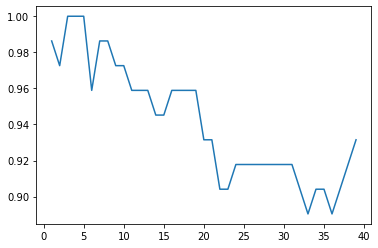

In [18]:
plt.plot(vrange, error_rate)
plt.show()